This cell load the data

In [52]:
import re
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Classic ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# NLP preprocessing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Seed + Plot style

In [53]:
SEED = 42

def set_seeds(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)

set_seeds(SEED)

sns.set_theme(style="whitegrid")

This cell Download NLTK resources

In [54]:
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)

True

POS mapping helper (lemmatization)

In [55]:
def get_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    if treebank_tag.startswith("V"):
        return wordnet.VERB
    if treebank_tag.startswith("N"):
        return wordnet.NOUN
    if treebank_tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

This cell is a cell to the textpreprocessor 

In [56]:
@dataclass
class TextPreprocessor:
    stop_words: set
    lemmatizer: WordNetLemmatizer

    def __call__(self, text: str) -> str:
        if not isinstance(text, str):
            return ""

        text = re.sub(r"[^\w\s]", " ", text)   # punctuation -> space
        text = re.sub(r"\d+", " ", text)       # digits -> space
        text = text.lower()

        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stop_words and len(t) > 1]

        tagged = pos_tag(tokens)
        lemmas = [self.lemmatizer.lemmatize(w, get_wordnet_pos(tag)) for w, tag in tagged]
        return " ".join(lemmas)

pre = TextPreprocessor(
    stop_words=set(stopwords.words("english")),
    lemmatizer=WordNetLemmatizer()
)

This cell load the dataset

In [57]:
DATA_PATH = "amazon_cells_labelled.txt"  

df = pd.read_csv(DATA_PATH, sep="\t", header=None, names=["text", "label"])
df = df.dropna().reset_index(drop=True)
df["label"] = df["label"].astype(int)

df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


A quick data check, data shape and missing value 

In [58]:
print("Shape:", df.shape)
print("\nLabel counts:\n", df["label"].value_counts())
print("\nMissing values:\n", df.isna().sum())

Shape: (1000, 2)

Label counts:
 label
0    500
1    500
Name: count, dtype: int64

Missing values:
 text     0
label    0
dtype: int64


label distribution: 0 for negative and 1 for positive 

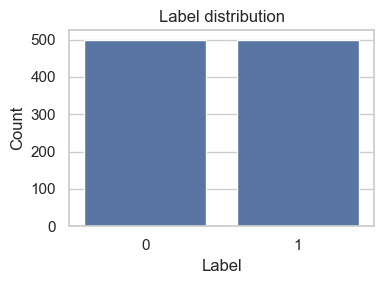

In [59]:
plt.figure(figsize=(4,3))
sns.countplot(x="label", data=df)
plt.title("Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Clean text with label distribution

In [60]:
df["text_clean"] = df["text"].apply(pre)
df[["text", "text_clean", "label"]].head(10)

,text,text_clean,label
0,So there is no way for me to plug it in here i...,way plug u unless go converter,0
1,"Good case, Excellent value.",good case excellent value,1
2,Great for the jawbone.,great jawbone,1
3,Tied to charger for conversations lasting more...,tie charger conversation last minute major pro...,0
4,The mic is great.,mic great,1
5,I have to jiggle the plug to get it to line up...,jiggle plug get line right get decent volume,0
6,If you have several dozen or several hundred c...,several dozen several hundred contact imagine ...,0
7,If you are Razr owner...you must have this!,razr owner must,1
8,"Needless to say, I wasted my money.",needless say waste money,0
9,What a waste of money and time!.,waste money time,0


Text length distribution raw text vs cleaned text

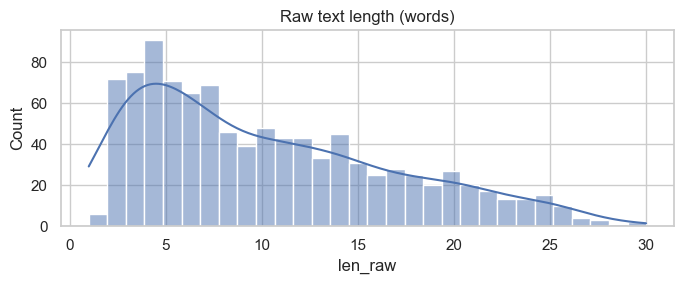

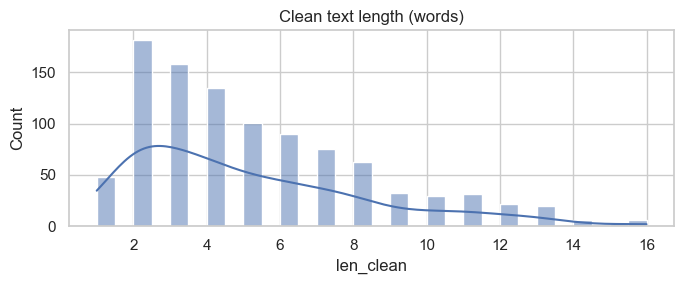

In [61]:
df["len_raw"] = df["text"].astype(str).str.split().str.len()
df["len_clean"] = df["text_clean"].astype(str).str.split().str.len()

plt.figure(figsize=(7,3))
sns.histplot(df["len_raw"], bins=30, kde=True)
plt.title("Raw text length (words)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
sns.histplot(df["len_clean"], bins=30, kde=True)
plt.title("Clean text length (words)")
plt.tight_layout()
plt.show()

Most common cleaned word 

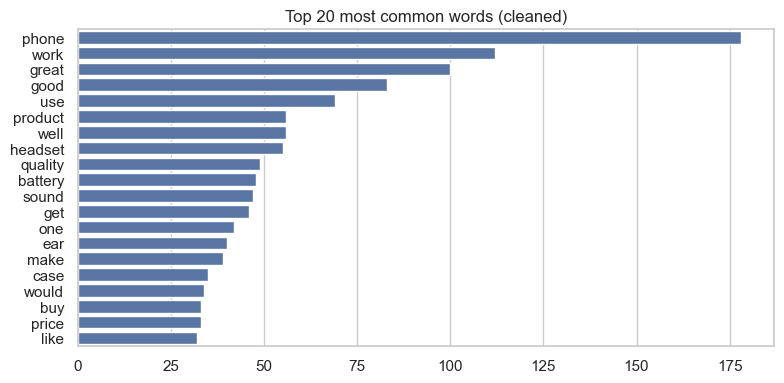

In [62]:
all_tokens = " ".join(df["text_clean"]).split()
counts = Counter(all_tokens)
top_words = counts.most_common(20)

words = [w for w, c in top_words]
freqs = [c for w, c in top_words]

plt.figure(figsize=(8,4))
sns.barplot(x=freqs, y=words)
plt.title("Top 20 most common words (cleaned)")
plt.tight_layout()
plt.show()

Top TF-IDF terms

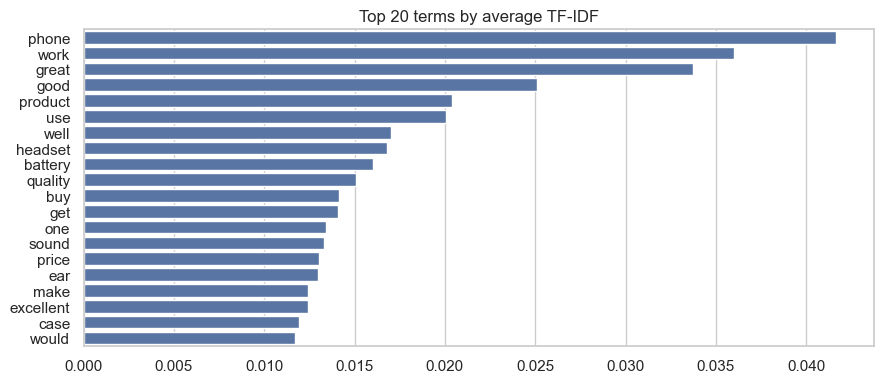

In [63]:
tfidf_tmp = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=2)
X_tmp = tfidf_tmp.fit_transform(df["text_clean"])
feature_names = np.array(tfidf_tmp.get_feature_names_out())

avg_tfidf = np.asarray(X_tmp.mean(axis=0)).ravel()
top_idx = avg_tfidf.argsort()[-20:][::-1]

top_terms = feature_names[top_idx]
top_vals = avg_tfidf[top_idx]

plt.figure(figsize=(9,4))
sns.barplot(x=top_vals, y=top_terms)
plt.title("Top 20 terms by average TF-IDF")
plt.tight_layout()
plt.show()

Train/test split (stratified)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"],
    df["label"],
    test_size=0.2,
    random_state=SEED,
    stratify=df["label"]
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Train label %:\n", y_train.value_counts(normalize=True))
print("Test label %:\n", y_test.value_counts(normalize=True))

Train: 800 Test: 200
Train label %:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Test label %:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


This cell define the baseline models 

In [65]:
models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "LinearSVM": LinearSVC(),
    "NaiveBayes": MultinomialNB(),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=SEED),
    "GradBoost": GradientBoostingClassifier(random_state=SEED),
    "KNN": KNeighborsClassifier(n_neighbors=7),
}

This cell Train + evaluate baselines (with confusion matrices)


LogReg
Accuracy: 0.7750
              precision    recall  f1-score   support

           0     0.7778    0.7700    0.7739       100
           1     0.7723    0.7800    0.7761       100

    accuracy                         0.7750       200
   macro avg     0.7750    0.7750    0.7750       200
weighted avg     0.7750    0.7750    0.7750       200



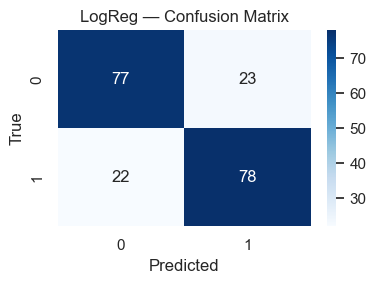


LinearSVM
Accuracy: 0.8300
              precision    recall  f1-score   support

           0     0.8367    0.8200    0.8283       100
           1     0.8235    0.8400    0.8317       100

    accuracy                         0.8300       200
   macro avg     0.8301    0.8300    0.8300       200
weighted avg     0.8301    0.8300    0.8300       200



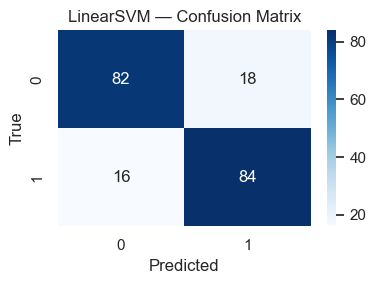


NaiveBayes
Accuracy: 0.7950
              precision    recall  f1-score   support

           0     0.8471    0.7200    0.7784       100
           1     0.7565    0.8700    0.8093       100

    accuracy                         0.7950       200
   macro avg     0.8018    0.7950    0.7938       200
weighted avg     0.8018    0.7950    0.7938       200



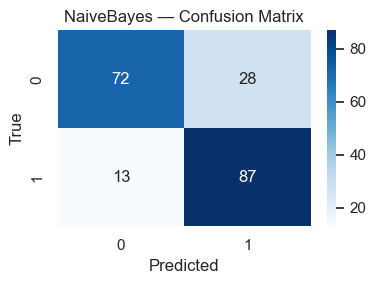


RandomForest
Accuracy: 0.7600
              precision    recall  f1-score   support

           0     0.7407    0.8000    0.7692       100
           1     0.7826    0.7200    0.7500       100

    accuracy                         0.7600       200
   macro avg     0.7617    0.7600    0.7596       200
weighted avg     0.7617    0.7600    0.7596       200



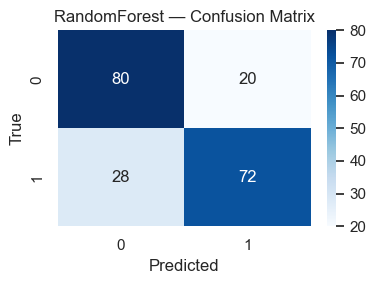


GradBoost
Accuracy: 0.7500
              precision    recall  f1-score   support

           0     0.7273    0.8000    0.7619       100
           1     0.7778    0.7000    0.7368       100

    accuracy                         0.7500       200
   macro avg     0.7525    0.7500    0.7494       200
weighted avg     0.7525    0.7500    0.7494       200



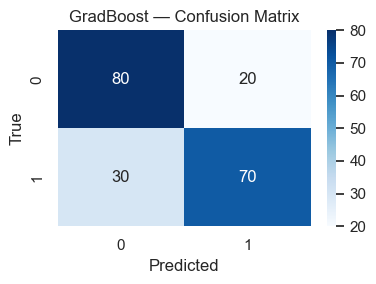


KNN
Accuracy: 0.7500
              precision    recall  f1-score   support

           0     0.8205    0.6400    0.7191       100
           1     0.7049    0.8600    0.7748       100

    accuracy                         0.7500       200
   macro avg     0.7627    0.7500    0.7469       200
weighted avg     0.7627    0.7500    0.7469       200



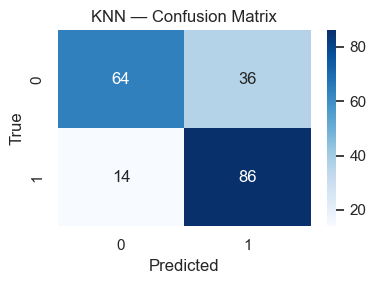

{'LogReg': 0.775,
 'LinearSVM': 0.83,
 'NaiveBayes': 0.795,
 'RandomForest': 0.76,
 'GradBoost': 0.75,
 'KNN': 0.75}

In [66]:
results: Dict[str, float] = {}
pipes: Dict[str, Pipeline] = {}

for name, model in models.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_df=0.9)),
        ("clf", model),
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds)
    results[name] = acc
    pipes[name] = pipe

    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, digits=4))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

results

This cell compare the baseline accuracies 

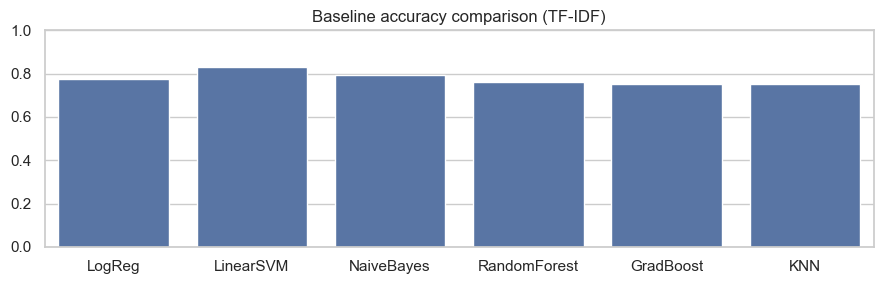

Best baseline: LinearSVM Accuracy: 0.83


In [67]:
plt.figure(figsize=(9,3))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Baseline accuracy comparison (TF-IDF)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

best_model_name = max(results, key=results.get)
print("Best baseline:", best_model_name, "Accuracy:", results[best_model_name])
best_pipe = pipes[best_model_name]

Predict on new text (baseline)

In [68]:
def predict_sentiment_baseline(texts):
    if isinstance(texts, str):
        texts = [texts]
    clean = [pre(t) for t in texts]
    preds = best_pipe.predict(clean)
    return ["positive" if p == 1 else "negative" for p in preds]

predict_sentiment_baseline(["This is amazing!", "Worst purchase ever."])

['positive', 'negative']

# Transformer Section 

In [69]:
!pip -q install transformers datasets evaluate accelerate

Transformer imports

In [70]:
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
import evaluate

Prepare HF datasets (stratified split in pandas)

In [71]:
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 128

train_df, test_df = train_test_split(
    df[["text", "label"]],
    test_size=0.2,
    random_state=SEED,
    stratify=df["label"]
)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH
    )

# remove_columns keeps dataset clean (text isn't needed after tokenization)
train_ds = train_ds.map(tokenize, batched=True, remove_columns=["text"])
test_ds = test_ds.map(tokenize, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

acc_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return acc_metric.compute(predictions=preds, references=labels)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Trainer + eval + train

In [72]:
args = TrainingArguments(
    output_dir="./transformer_results",
    eval_strategy="epoch",     # <-- older versions use this
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    seed=SEED,
    report_to="none",
    logging_steps=50,
)

Transformer confusion matrix

In [73]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
metrics = trainer.evaluate()
metrics

Epoch,Training Loss,Validation Loss,Accuracy
1,0.365753,0.279387,0.915000
2,0.143333,0.260064,0.910000


{'eval_loss': 0.260064035654068,
 'eval_accuracy': 0.91,
 'eval_runtime': 3.9273,
 'eval_samples_per_second': 50.925,
 'eval_steps_per_second': 3.31,
 'epoch': 2.0}

Transformer confusion matrix

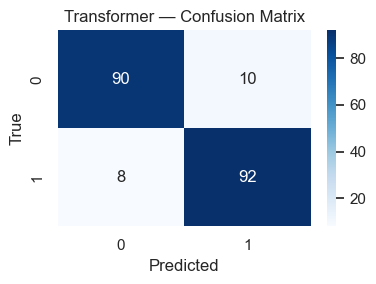

              precision    recall  f1-score   support

           0     0.9184    0.9000    0.9091       100
           1     0.9020    0.9200    0.9109       100

    accuracy                         0.9100       200
   macro avg     0.9102    0.9100    0.9100       200
weighted avg     0.9102    0.9100    0.9100       200



In [74]:
pred_out = trainer.predict(test_ds)
preds = np.argmax(pred_out.predictions, axis=-1)
labels = pred_out.label_ids

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Transformer — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(classification_report(labels, preds, digits=4))

Training curve (loss over steps)

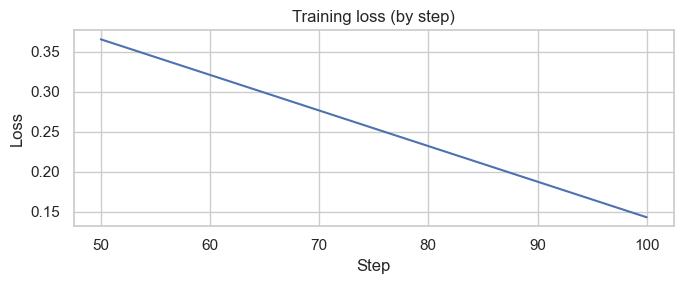

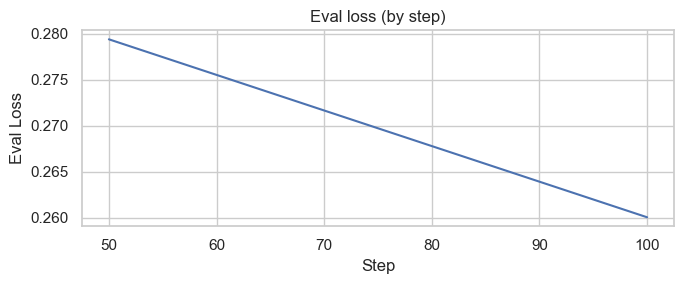

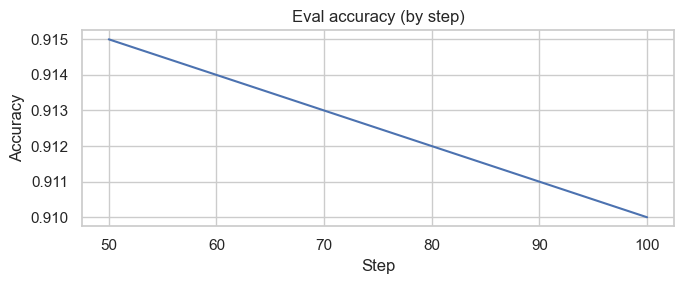

In [75]:
log_history = trainer.state.log_history

train_steps = []
train_losses = []
eval_steps = []
eval_losses = []
eval_accs = []

for row in log_history:
    if "loss" in row and "step" in row and "eval_loss" not in row:
        train_steps.append(row["step"])
        train_losses.append(row["loss"])
    if "eval_loss" in row and "step" in row:
        eval_steps.append(row["step"])
        eval_losses.append(row["eval_loss"])
        if "eval_accuracy" in row:
            eval_accs.append((row["step"], row["eval_accuracy"]))

if train_steps:
    plt.figure(figsize=(7,3))
    plt.plot(train_steps, train_losses)
    plt.title("Training loss (by step)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

if eval_steps:
    plt.figure(figsize=(7,3))
    plt.plot(eval_steps, eval_losses)
    plt.title("Eval loss (by step)")
    plt.xlabel("Step")
    plt.ylabel("Eval Loss")
    plt.tight_layout()
    plt.show()

if eval_accs:
    steps, accs = zip(*eval_accs)
    plt.figure(figsize=(7,3))
    plt.plot(steps, accs)
    plt.title("Eval accuracy (by step)")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

Predict on new text (Transformer)

In [76]:
import torch

def predict_sentiment_transformer(texts: List[str]) -> List[str]:
    if isinstance(texts, str):
        texts = [texts]
    enc = tokenizer(texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
    with torch.no_grad():
        out = model(**enc)
        preds = torch.argmax(out.logits, dim=-1).cpu().numpy()
    return ["positive" if p == 1 else "negative" for p in preds]

predict_sentiment_transformer(["I love this!", "This is terrible."])

['positive', 'negative']